## Libraries

### Programming for Data Science (ID2214)

### Amir H. Rahnama (Twitter: @_ambodi)

#### Ph.D. Candidate 


<img src="https://www.kth.se/polopoly_fs/1.77259!/KTH_Logotyp_RGB_2013-2.svg" alt="kth_logo" style="width:200px;"/>

### Preface

In this lecture, we will be focusing on the use of libraries in our data science and Machine Learning projects. Just like the last lecture, our focus will be to solve the whole problem from the data gathering until modelling, so that you can have a grasp of how a *semi* real-world project works. 

The *outline* of this lecture are: 
* Boosting methods in practice
    * Sklearn's AdaBoostRegressor
    * Sklearn's GradientBoostingRegressor
    * Xgboost's package
* A brief introduction to Artificial Neural Networks
    * What is an Artificial Neural Network? 
    * Training with Backpropagation
    * How does XGBoost compare to a Multi-layer Perceptron? 
* Understanding how to wortk with Tensorflow and Keras
    * Modelling
    * Hyper-parameter Optimization
* Use GPUs in order to accelerate reading/manipulating/modelling of big chunks of data
    * Computation using GPU versions of Numpy
    * Benchmarks on CPU/GPU version

### Adaptive Boosting and Gradient Boosting

We will be continuing today's lecture with more sophisticated ensemble trees, namely **AdaBoost** and **Gradient Boosting**. According to Wikipedia, in AdaBoost, the output of the other learning algorithms ('weak learners') is combined into a weighted sum that represents the final output of the boosted classifier. AdaBoost is adaptive in the sense that subsequent weak learners are tweaked in favor of those instances misclassified by previous classifiers. 

As also mentioned in the Wikipedia article, Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. Gradient boosting is typically used with decision trees (especially CART trees) of a fixed size as base learners. 

In this lecture, we will be working with a different implementation of Gradient Boosting, namely XGBoost and more on that later, but for now, we will continue with Scikit Learn. 

We will show you the Sklearn's implementation of Adaptive and Gradient Boosting, namely **sklearn.ensemble.AdaBoostRegressor** and **sklearn.ensemble.GradientBoostingClassifier**.

In addition, in this lecture we will be working with regression so that you have had enough practical experience working with both classification and regression problems in this course. We will work with the famous Boston Housing Dataset: https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html

In [1]:
from sklearn import datasets

boston = datasets.load_boston()

In [2]:
boston.data.shape

(506, 13)

In [3]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

Here is a short description of the features:

   * **CRIM** : per capita crime rate by town
   * **ZN** : proportion of residential land zoned for lots over 25,000 sq.ft.
   * **INDUS** : proportion of non-retail business acres per town.
   * **CHAS** : Charles River dummy variable (1 if tract bounds river; 0 otherwise)
   * **NOX** : nitric oxides concentration (parts per 10 million)
   * **RM** : average number of rooms per dwelling
   * **AGE** : proportion of owner-occupied units built prior to 1940
   * **DIS** : weighted distances to five Boston employment centres
   * **RAD** : index of accessibility to radial highways
   * **TAX** : full-value property-tax rate per 10,000 USD
   * **PTRATIO** : pupil-teacher ratio by town
   * **B** : 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
   * **LSTAT** : (percentage) lower status of the population
   * **MEDV** : Median value of owner-occupied homes in $1000's
   
And the targe values:

In [4]:
boston.target

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

Let us start by a simple case of comparison between Adaptive and Gradient Boosting, without thinking too much about the parameters and hyperparameter. Before we start, we need to run our cross validation. Unfortunately due to a limitation in ScikitLearn's API, we cannot use the *validation_curve* and we need to do it manually:

In [5]:
#Fix the random state
import numpy as np
from sklearn.model_selection import train_test_split

rng = np.random.RandomState(1)

#Divide the data
X_train, X_test, y_train, y_test = train_test_split(boston.data, 
                                                    boston.target, test_size=0.2, random_state=rng)

X_train, X_val, y_train, y_val = train_test_split(boston.data, 
                                                    boston.target, test_size=0.2, random_state=rng)

In [6]:
(X_train.shape, y_train.shape), (X_val.shape, y_val.shape), (X_test.shape, y_test.shape)

(((404, 13), (404,)), ((102, 13), (102,)), ((102, 13), (102,)))

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
import numpy as np


regr_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4, random_state=rng),
                          n_estimators=300, random_state=rng)
regr_gboost = GradientBoostingRegressor(loss='quantile', 
                                  n_estimators=300,learning_rate=.1, max_depth=4, random_state=rng)

regr_ada.fit(X_train, y_train)
regr_gboost.fit(X_train, y_train)

y_ada = regr_ada.predict(X_test)
y_gboost = regr_gboost.predict(X_test)

In [8]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(19, 6), sharex=True, sharey=True)

ax[0].scatter(y_test, y_ada, label='Adaptive Boosting', alpha=0.7, color='red')
ax[0].plot(y_test, y_test, label='Groud Truth', alpha=0.7, color='green')
ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predicted Values')
ax[0].legend()

ax[1].scatter(y_test, y_gboost, label='Gradient Boosting', alpha=0.7, color='blue')
ax[1].plot(y_test, y_test, label='Groud Truth', alpha=0.7, color='green')
ax[1].set_xlabel('True Values')
ax[1].legend()


fig.suptitle("Boston Housing Regression: Truth vs. Predicted")
plt.show()

<Figure size 1900x600 with 2 Axes>

### Error Analysis

In case of regression, usually we measure the error in prediction. **Mean Squared Error** and **Mean Absolute Error** and **R2 score** are common ways of measuring errors in your prediction. MSE is not very robust to outliers, therefore MAE is prefered when there is a case there are outliers in our dataset. R2 score shows the percentage of squared correlation between the predicted and real values of the target variable.

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_ada = mean_squared_error(y_test, y_ada)
mse_gboost = mean_squared_error(y_test, y_gboost)

mae_ada = mean_absolute_error(y_test, y_ada)
mae_gboost = mean_absolute_error(y_test, y_gboost)

r2_ada = r2_score(y_test, y_ada)
r2_gboost = r2_score(y_test, y_gboost)

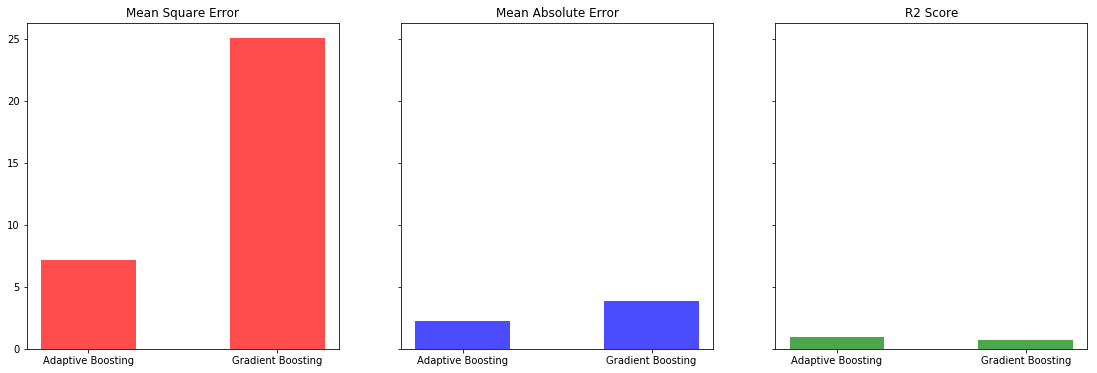

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 3, figsize=(19, 6), sharex=True, sharey=True)

N = np.arange(2)
width = 0.5

ax[0].bar(N, [mse_ada, mse_gboost], width, label='Mean Square Error', alpha=0.7, color='red')
ax[0].set_xticks(N)
ax[0].set_xticklabels(('Adaptive Boosting', 'Gradient Boosting'))
ax[0].set_title('Mean Square Error')

ax[1].bar(N, [mae_ada, mae_gboost], width, label='Mean Asbolute Error', alpha=0.7, color='blue')
ax[1].set_xticks(N)
ax[1].set_xticklabels(('Adaptive Boosting', 'Gradient Boosting'))
ax[1].set_title('Mean Absolute Error')

ax[2].bar(N, [r2_ada, r2_gboost], width, label='R2 Score', alpha=0.7, color='green')
ax[2].set_xticks(N)
ax[2].set_xticklabels(('Adaptive Boosting', 'Gradient Boosting'))
ax[2].set_title('R2 Score')

plt.show()

In all three measures, Adaptive Boosting outperforms Gradient Boosting in all measures. The reason could be due to over-fitting of Gradient Boosting, since Gradient Boosting has a lot of key learning parameters to be adjusted. 

Speaking of hyper-parameters, let us perform a simple analysis of how a common parameter such as **max_depth** that is shared across all models is better tuned. Let us have a look:

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

max_depths = np.linspace(1, 32, 32, endpoint=True)

mse_ada_md = []
mse_gboost_md = []

mae_ada_md = []
mae_gboost_md = []

r2_ada_md = []
r2_gboost_md = []


for max_depth in max_depths:
    reg_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),
                          n_estimators=300, random_state=rng)
    reg_gboost = GradientBoostingRegressor(loss='quantile', 
                                  n_estimators=300,learning_rate=.1, max_depth=4, 
                                  random_state=rng)

    reg_ada.fit(X_train, y_train)
    reg_gboost.fit(X_train, y_train)

    y_ada = reg_ada.predict(X_val)
    y_gboost = reg_gboost.predict(X_val)
    
    mse_ada_md.append(mean_squared_error(y_val, y_ada))
    mse_gboost_md.append(mean_squared_error(y_val, y_gboost))
    
    mae_ada_md.append(mean_absolute_error(y_val, y_ada))
    mae_gboost_md.append(mean_absolute_error(y_val, y_gboost))
    
    r2_ada_md.append(r2_score(y_val, y_ada))
    r2_gboost_md.append(r2_score(y_val, y_gboost))

So let us visualize the results in a pair gridplot between the *max_depth* and all of our errors:

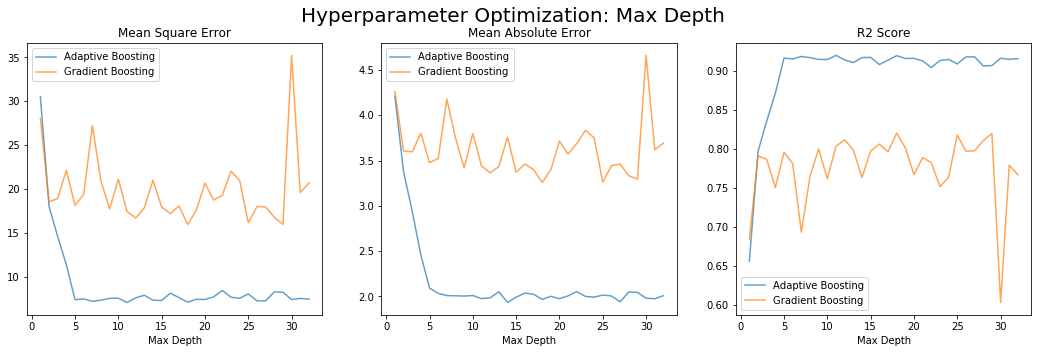

In [12]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

ax[0].plot(max_depths, mse_ada_md, label='Adaptive Boosting', alpha=0.7)
ax[0].plot(max_depths, mse_gboost_md, label='Gradient Boosting', alpha=0.7)
ax[0].set_xlabel('Max Depth')
ax[0].set_title("Mean Square Error")
ax[0].legend()

ax[1].plot(max_depths, mae_ada_md, label='Adaptive Boosting', alpha=0.7)
ax[1].plot(max_depths, mae_gboost_md, label='Gradient Boosting', alpha=0.7)
ax[1].set_xlabel('Max Depth')
ax[1].set_title("Mean Absolute Error")
ax[1].legend()

ax[2].plot(max_depths, r2_ada_md, label='Adaptive Boosting', alpha=0.7)
ax[2].plot(max_depths, r2_gboost_md, label='Gradient Boosting', alpha=0.7)
ax[2].set_xlabel('Max Depth')
ax[2].set_title("R2 Score")
ax[2].legend()

fig.suptitle('Hyperparameter Optimization: Max Depth', fontsize=20)

plt.show()

**Adaptive Boosting** performs best when the depth is 5, however its error stops to improve in both MSE and MAE case. **Gradient Boosting** respond the same way to the depth, however as you can see in the chart, **Gradient Boosting** fluctuates a lot with different *max_depth* values.

Let us fix the value of *max_depth* to 3 according to our validation set, and continue with another common hyper-parameter across all three models, *min_samples_split*:

In [13]:
min_samples_splits = np.linspace(0.1, 1.0, 20, endpoint=True)

mse_ada_mss = []
mse_gboost_mss = []

mae_ada_mss = []
mae_gboost_mss = []

r2_ada_mss = []
r2_gboost_mss = []

for min_split in min_samples_splits:
    reg_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth, min_samples_split=min_split),
                          n_estimators=300, random_state=rng)
    reg_gboost = GradientBoostingRegressor(loss='quantile', min_samples_split=min_split,
                                  n_estimators=300,learning_rate=.1, max_depth=4, 
                                  random_state=rng)

    reg_ada.fit(X_train, y_train)
    reg_gboost.fit(X_train, y_train)

    y_ada = reg_ada.predict(X_val)
    y_gboost = reg_gboost.predict(X_val)
    
    mse_ada_mss.append(mean_squared_error(y_val, y_ada))
    mse_gboost_mss.append(mean_squared_error(y_val, y_gboost))
    
    mae_ada_mss.append(mean_absolute_error(y_val, y_ada))
    mae_gboost_mss.append(mean_absolute_error(y_val, y_gboost))
    
    r2_ada_mss.append(r2_score(y_val, y_ada))
    r2_gboost_mss.append(r2_score(y_val, y_gboost))

Let us plot the min sample splits across all types of errors:

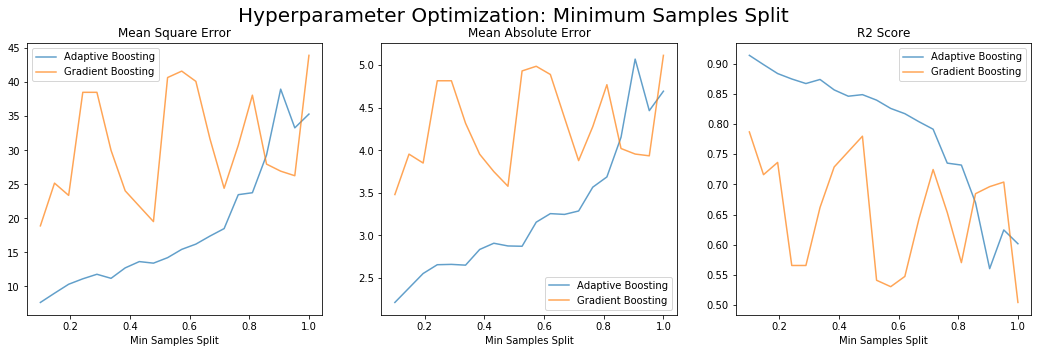

In [14]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

ax[0].plot(min_samples_splits, mse_ada_mss, label='Adaptive Boosting', alpha=0.7)
ax[0].plot(min_samples_splits, mse_gboost_mss, label='Gradient Boosting', alpha=0.7)
ax[0].set_xlabel('Min Samples Split')
ax[0].set_title('Mean Square Error')
ax[0].legend()

ax[1].plot(min_samples_splits, mae_ada_mss, label='Adaptive Boosting', alpha=0.7)
ax[1].plot(min_samples_splits, mae_gboost_mss, label='Gradient Boosting', alpha=0.7)
ax[1].set_xlabel('Min Samples Split')
ax[1].set_title('Mean Absolute Error')
ax[1].legend()

ax[2].plot(min_samples_splits, r2_ada_mss, label='Adaptive Boosting', alpha=0.7)
ax[2].plot(min_samples_splits, r2_gboost_mss, label='Gradient Boosting', alpha=0.7)
ax[2].set_xlabel('Min Samples Split')
ax[2].set_title('R2 Score')
ax[2].legend()

fig.suptitle('Hyperparameter Optimization: Minimum Samples Split', fontsize=20)

plt.show()

When looking at these charts, we can see that **Adaptive Boosting** performs best with small values of splits, i.e. *min_samples_split=0.1*, however Gradient Boosting performs *almost* the same at the 0.1 and 0.9 which needs further investigation in this case, however this will be outside of the scope of this lecture:

### XGboost

According to its documentation, "XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way." In short, XGboost is a highly optimized Gradient Boosting model. 

The model has many more advantages compare to the Scikit Learn's Gradient Boosting. It allows for a more detailed parameter and hyperparameter tuning, and so forth. For more information, read "XGBoost: A Scalable Tree Boosting System" by Chen and Guestrin (2016).

Let us have a look at how to load and predict the data using Xgboost. First we need to install the package:

In [15]:
!pip install xgboost

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [16]:
import xgboost as xgb

xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 4, alpha = 10, n_estimators = 300, seed=1)

xg_reg.fit(X_train,y_train)

y_xgboost = xg_reg.predict(X_test)

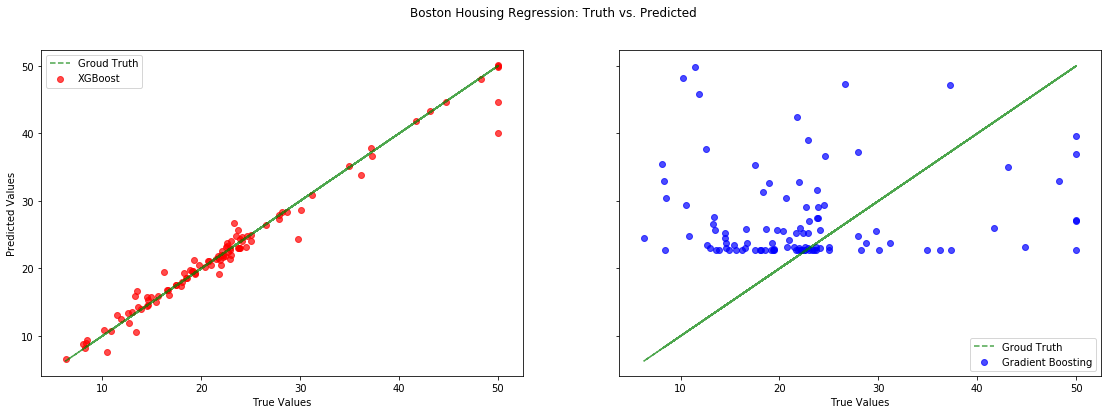

In [17]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(19, 6), sharex=True, sharey=True)

ax[0].scatter(y_test, y_xgboost, label='XGBoost', alpha=0.7, color='red')
ax[0].plot(y_test, y_test, label='Groud Truth', alpha=0.7, color='green', linestyle='--')
ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predicted Values')
ax[0].legend()

ax[1].scatter(y_test, y_gboost, label='Gradient Boosting', alpha=0.7, color='blue')
ax[1].plot(y_test, y_test, label='Groud Truth', alpha=0.7, color='green', linestyle='--')
ax[1].set_xlabel('True Values')
ax[1].legend()


fig.suptitle("Boston Housing Regression: Truth vs. Predicted")
plt.show()

As mentioned before, the implementation details of the two models are different, however we choose the same values for the ones both share, which as you can see results in two different predictions. The fact checking of using different packages in your data science projects is of utmost importance, especially when comparing and benchmarking models. 

In this case, we knew that these two pacakges have been implemented differently. How does **XGboost** perform with regards to *max_depth*? Let us have a look:

In [18]:
import xgboost as xgb

max_depths = np.linspace(1, 32, 32).astype(np.int32)

mse_xgboost_md = []
mae_xgboost_md = []
r2_xgboost_md = []


for max_depth in max_depths:
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = max_depth, alpha = 10, n_estimators = 300, seed=1)
    xg_reg.fit(X_train,y_train)
    y_xgboost = xg_reg.predict(X_val)

    
    mse_xgboost_md.append(mean_squared_error(y_val, y_xgboost))
    mae_xgboost_md.append(mean_absolute_error(y_val, y_xgboost))
    r2_xgboost_md.append(r2_score(y_val, y_xgboost))

Let us look at the error between XGboost and Gradient Boosting from Sklearn:

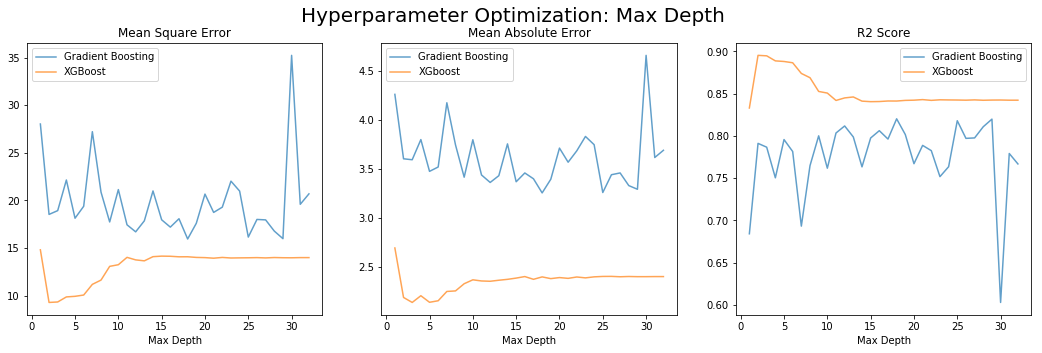

In [19]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

ax[0].plot(max_depths, mse_gboost_md, label='Gradient Boosting', alpha=0.7)
ax[0].plot(max_depths, mse_xgboost_md, label='XGBoost', alpha=0.7)
ax[0].set_xlabel('Max Depth')
ax[0].set_title("Mean Square Error")
ax[0].legend()

ax[1].plot(max_depths, mae_gboost_md, label='Gradient Boosting', alpha=0.7)
ax[1].plot(max_depths, mae_xgboost_md, label='XGboost', alpha=0.7)
ax[1].set_xlabel('Max Depth')
ax[1].set_title("Mean Absolute Error")
ax[1].legend()

ax[2].plot(max_depths, r2_gboost_md, label='Gradient Boosting', alpha=0.7)
ax[2].plot(max_depths, r2_xgboost_md, label='XGboost', alpha=0.7)
ax[2].set_xlabel('Max Depth')
ax[2].set_title("R2 Score")
ax[2].legend()

fig.suptitle('Hyperparameter Optimization: Max Depth', fontsize=20)

plt.show()

XGboost performs at its best in smaller depths and its minum error is at **max_depth=2** and in all cases it out-performs the gradient boosting from Sklearn, which at this point should not a surprise, since XGboost enjoyts a much more optimized implementation.

We will finish this section with a short performance analysis of the package. One of the many reasons that **XGboost** is popular is due to its performance. Let us have a look:

### XGboost performance compared to Sklearn's Gradient Boosting

We will examine the performance differences between XGboost and Scikit Learn's implementation. We will check the performance at both training and prediction phases:

In [20]:
import xgboost as xgb
import time

fit_time_xgboost = []
pred_time_xgboost = []

repetitions = np.linspace(1, 100, 100).astype(np.int32)

for repetition in repetitions:
    start_fit_time_xgboost = time.time()
    xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                          colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = max_depth, alpha = 10, n_estimators = 300, seed=1)
    y_xgboost = xg_reg.fit(X_train,y_train)
    end_fit_time_xgboost = time.time()
    
    start_pred_time_xgboost = time.time()
    y_xgboost = xg_reg.predict(X_test)
    end_pred_time_xgboost = time.time()
    
    fit_time_xgboost.append(end_fit_time_xgboost - start_fit_time_xgboost)
    pred_time_xgboost.append(end_pred_time_xgboost - start_pred_time_xgboost)

fit_time_gboost = []
pred_time_gboost = []

for repetition in repetitions:
    start_fit_time_gboost = time.time()
    regr_gboost = GradientBoostingRegressor(loss='quantile', 
                                  n_estimators=300,learning_rate=.1, max_depth=4, random_state=rng)
    regr_gboost.fit(X_train, y_train)
    end_fit_time_gboost = time.time()
    
    start_pred_time_gboost = time.time()
    y_gboost = regr_gboost.predict(X_test)
    end_pred_time_gboost = time.time()
    
    fit_time_gboost.append(end_fit_time_gboost - start_fit_time_gboost)
    pred_time_gboost.append(end_pred_time_gboost - start_pred_time_gboost)
    

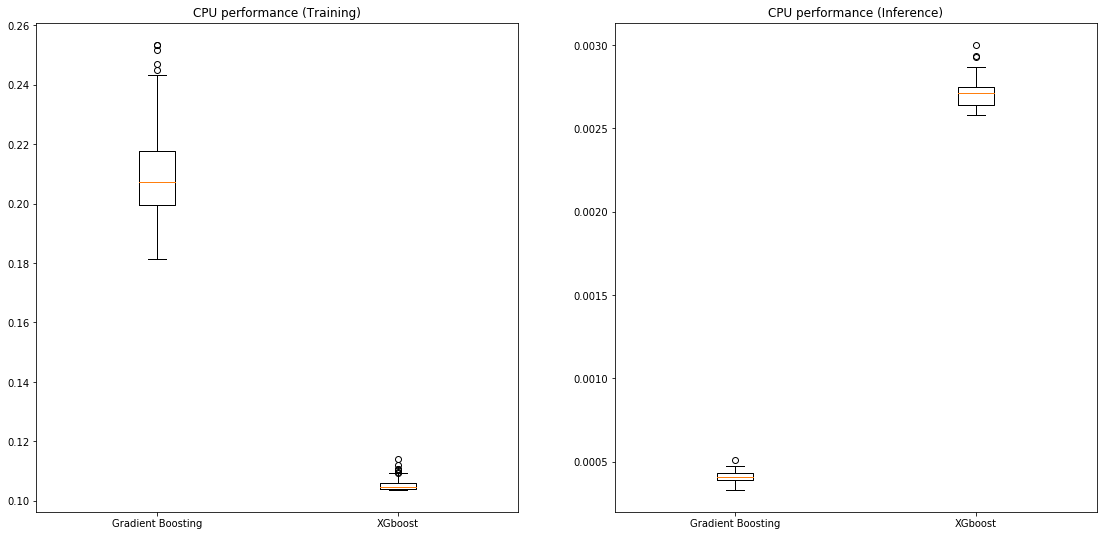

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(19, 9))

ax[0].set_title('CPU performance (Training)')
ax[0].boxplot([fit_time_gboost, fit_time_xgboost])
ax[0].set_xticklabels(('Gradient Boosting', 'XGboost'))

ax[1].set_title('CPU performance (Inference)')
ax[1].boxplot([pred_time_gboost, pred_time_xgboost])
ax[1].set_xticklabels(('Gradient Boosting', 'XGboost'))

plt.show()

As expected, XGboost outperforms the Gradient Boosting, however we see another interesting result that Scikit Learn outperforms the XGboost in the prediction phase. This needs further investigation, bearing in mind that the implementations are very different in many aspects.

### A brief introduction to Neural Networks

According to Wikipedia, "Artificial Neural Networks (ANN) or connectionist systems are computing systems vaguely inspired by the biological neural networks that constitute animal brains.[1] The neural network itself is not an algorithm, but rather a framework for many different machine learning algorithms to work together and process complex data inputs". Artificial Neural Networks have lately gained recognition to their ability to model highly non-linear mappings, which is very valuable when working with digital images and text.

There are three main components in an Aritificial Neural Network:
   * **Neuron**: a computational unit that has three components:
       * an input weight connection
       * an output weight connection
       * an activation function
   * **Backpropagation algorithm**: using backpropagation, neural networks learn to minimze the cost, or in Neural Network literature, loss functions
   * **Weights or connections**: Each neuron is connected to at least one other neuron by a weight vector which controls the effect that the output of one neuron has for another

#### Achitecture:

<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/ArtificialNeuronModel_english.png" style="width:600px"/>

Source: [Artificial Intelligence, Deep Learning, and Neural Networks, Explained](https://www.kdnuggets.com/2016/10/artificial-intelligence-deep-learning-neural-networks-explained.html)

### Neuron


In order to imagine the concept of a neuron, you can think in terms of matrix multiplications. Let us demonstrate this case:

In [24]:
import numpy as np
import tensorflow as tf

inp = np.random.random((10, 2))
w = np.random.random((2, 1))

pre_activation = np.dot(inp, w)

As you can see, there is a strict constarint that the input and its corresponding weight should share the same second dimension, else the algorithm cannot perform the matrix multiplication.

Let us have a look at the shape of our data now:

In [25]:
pre_activation.shape

(10, 1)

Now let us activate these pre activation values by passing them into the activation function, but before we need to sum up the values:

In [27]:
import math 

def sigmoid_activation(x):
    return 1 / (1 + np.exp(-x))

activation =sigmoid_activation(pre_activation)

In [28]:
activation.shape

(10, 1)

In [29]:
activation

array([[0.62835743],
       [0.59636398],
       [0.63192334],
       [0.53560484],
       [0.57841626],
       [0.62109096],
       [0.55905965],
       [0.6360956 ],
       [0.52716574],
       [0.61328496]])

### Backpropagation:

The above code we wrote is actually the first part of the learning in the backproapgation algorithm, called forward pass. This is a pseudocode:

<script type="text/javascript" src="http://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML"></script>

```python
initialize network weights (often small random values)
  do
     forEach training example named ex
        prediction = neural-net-output(network, ex)  // forward pass
        actual = teacher-output(ex)
        compute error (prediction - actual) at the output units
        compute Δ w h Delta w_h, for all weights from hidden layer to output layer  // backward pass
        compute Δ w i Delta w_i, for all weights from input layer to hidden layer   // backward pass 
        update network weights // input layer not modified by error estimate
  until all examples classified correctly or another stopping criterion satisfied
  return the network
```

*Source: Wikipedia entry of Backpropagation*

Backpropagation is a variant of an important learning algorithm called Stochastic Gradient Descent. "Stochastic gradient descent (often shortened to SGD), also known as incremental gradient descent, is an iterative method for optimizing a differentiable objective function, a stochastic approximation of gradient descent optimization", as cited in the Wikipedia article.

In order to grasp the way Stochastic Gradient Descent works, let us look at a visualization of different variations of Stochastic Gradient Descent (all visualization are taken from: https://imgur.com/a/Hqolp.

Let us first have a look at how the algorithm finds minmum values in a normal 3-D surface called **Rosenbrock function**, in which the global minimum is inside a long and narrow flat valley: 

<img src="https://i.imgur.com/2dKCQHh.gif?1" />

And have a look at **Beale function**:

<img src="https://i.imgur.com/NKsFHJb.gif?1" />

### Tensorflow

As said in the corresponding Wikipedia article, "TensorFlow is an open-source software library for dataflow programming across a range of tasks. It is a symbolic math library, and is also used for machine learning applications such as neural networks."

As you can see from our small exercise, writing performance efficient code for Neural Networks can be tricky. Not only that, there are many corner cases in which calculating gradients of large matrix can be error-prone. It is advisable to use trusted libraries like Tensorflow in order to be on the safe side.


In this part of the lecture, we will be solving our Boston Housing problem, using Tensorflow. First let us start by a simple demo of a service from Tensorflow called [A Neural Network Playground](https://playground.tensorflow.org)

In [30]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.5.0


As you can see, in this lecture we are covering the Tensorflow 1.5. The Tensorflow API changes so rapidly, therefore it is important that you checkout the relevant documentation:

Unfortunately due to an inconsistency in the Tensorflow API, we need to run the cross validation process again, since the API does not let us control the validation set, and randomly chunks the training data by a **validation_split** parameter, later when the **fit** method is called:

In [32]:
from numpy.random import seed
from tensorflow import set_random_seed

from sklearn import datasets
from sklearn.model_selection import train_test_split

seed(1)
set_random_seed(2)
rng = np.random.RandomState(1)


boston = datasets.load_boston()

#Divide the data
x_train, X_test, y_train, y_test = train_test_split(boston.data, 
                                                    boston.target, test_size=0.2, random_state=rng)

# Shuffle the training set
order = np.argsort(np.random.random(y_train.shape))
X_train = x_train[order]
y_train = y_train[order]

In [33]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(X_train.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(1)
  ])

    optimizer = tf.train.RMSPropOptimizer(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return model

model_rmsprop = build_model()
model_rmsprop.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [34]:
EPOCHS = 500

# Store training stats
history_rmsprop = model_rmsprop.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=1)

Train on 323 samples, validate on 81 samples
Epoch 1/500
323/323 [==============================]323/323 [==============================] - 0s 1ms/step - loss: 1168.6879 - mean_absolute_error: 19.4564 - val_loss: 139.5384 - val_mean_absolute_error: 8.4981

Epoch 2/500
323/323 [==============================]323/323 [==============================] - 0s 49us/step - loss: 108.8856 - mean_absolute_error: 7.8281 - val_loss: 359.1174 - val_mean_absolute_error: 15.9881

Epoch 3/500
323/323 [==============================]323/323 [==============================] - 0s 53us/step - loss: 142.4485 - mean_absolute_error: 8.8144 - val_loss: 100.0713 - val_mean_absolute_error: 8.4100

Epoch 4/500
323/323 [==============================]323/323 [==============================] - 0s 51us/step - loss: 241.8327 - mean_absolute_error: 12.1756 - val_loss: 157.1171 - val_mean_absolute_error: 9.3944

Epoch 5/500
323/323 [==============================]323/323 [==============================] - 0s 56us/step 

323/323 [==============================]323/323 [==============================] - 0s 50us/step - loss: 58.7124 - mean_absolute_error: 5.6421 - val_loss: 48.7978 - val_mean_absolute_error: 4.6602

Epoch 40/500
323/323 [==============================]323/323 [==============================] - 0s 49us/step - loss: 90.9399 - mean_absolute_error: 7.3429 - val_loss: 87.6750 - val_mean_absolute_error: 8.2097

Epoch 41/500
323/323 [==============================]323/323 [==============================] - 0s 52us/step - loss: 69.1315 - mean_absolute_error: 6.5275 - val_loss: 79.4690 - val_mean_absolute_error: 6.1626

Epoch 42/500
323/323 [==============================]323/323 [==============================] - 0s 52us/step - loss: 85.9597 - mean_absolute_error: 7.4567 - val_loss: 106.6359 - val_mean_absolute_error: 7.6924

Epoch 43/500
323/323 [==============================]323/323 [==============================] - 0s 49us/step - loss: 91.1949 - mean_absolute_error: 7.5712 - val_loss: 44.12

323/323 [==============================]323/323 [==============================] - 0s 49us/step - loss: 46.1268 - mean_absolute_error: 5.0132 - val_loss: 188.3818 - val_mean_absolute_error: 12.2211

Epoch 79/500
323/323 [==============================]323/323 [==============================] - 0s 58us/step - loss: 49.1729 - mean_absolute_error: 5.0874 - val_loss: 60.1206 - val_mean_absolute_error: 5.4604

Epoch 80/500
323/323 [==============================]323/323 [==============================] - 0s 54us/step - loss: 59.7598 - mean_absolute_error: 5.9720 - val_loss: 103.2053 - val_mean_absolute_error: 7.8678

Epoch 81/500
323/323 [==============================]323/323 [==============================] - 0s 54us/step - loss: 52.8182 - mean_absolute_error: 5.4236 - val_loss: 44.3270 - val_mean_absolute_error: 4.3563

Epoch 82/500
323/323 [==============================]323/323 [==============================] - 0s 49us/step - loss: 49.7310 - mean_absolute_error: 5.3370 - val_loss: 143


Epoch 117/500
323/323 [==============================]323/323 [==============================] - 0s 52us/step - loss: 51.8669 - mean_absolute_error: 5.4476 - val_loss: 32.6188 - val_mean_absolute_error: 4.2854

Epoch 118/500
323/323 [==============================]323/323 [==============================] - 0s 48us/step - loss: 37.9226 - mean_absolute_error: 4.7057 - val_loss: 62.1561 - val_mean_absolute_error: 5.8750

Epoch 119/500
323/323 [==============================]323/323 [==============================] - 0s 48us/step - loss: 52.7093 - mean_absolute_error: 5.7630 - val_loss: 38.2758 - val_mean_absolute_error: 5.0118

Epoch 120/500
323/323 [==============================]323/323 [==============================] - 0s 53us/step - loss: 38.3530 - mean_absolute_error: 4.6971 - val_loss: 32.0573 - val_mean_absolute_error: 4.0303

Epoch 121/500
323/323 [==============================]323/323 [==============================] - 0s 46us/step - loss: 48.1695 - mean_absolute_error: 5.3573


Epoch 156/500
323/323 [==============================]323/323 [==============================] - 0s 61us/step - loss: 42.7943 - mean_absolute_error: 5.2423 - val_loss: 28.5715 - val_mean_absolute_error: 3.9190

Epoch 157/500
323/323 [==============================]323/323 [==============================] - 0s 52us/step - loss: 29.0443 - mean_absolute_error: 4.0302 - val_loss: 36.7214 - val_mean_absolute_error: 4.8251

Epoch 158/500
323/323 [==============================]323/323 [==============================] - 0s 51us/step - loss: 32.3427 - mean_absolute_error: 4.3205 - val_loss: 33.3128 - val_mean_absolute_error: 3.7647

Epoch 159/500
323/323 [==============================]323/323 [==============================] - 0s 59us/step - loss: 30.8702 - mean_absolute_error: 4.1657 - val_loss: 28.3848 - val_mean_absolute_error: 3.4169

Epoch 160/500
323/323 [==============================]323/323 [==============================] - 0s 54us/step - loss: 40.9976 - mean_absolute_error: 4.8090


Epoch 195/500
323/323 [==============================]323/323 [==============================] - 0s 50us/step - loss: 34.2969 - mean_absolute_error: 4.5934 - val_loss: 55.0441 - val_mean_absolute_error: 5.7838

Epoch 196/500
323/323 [==============================]323/323 [==============================] - 0s 48us/step - loss: 27.9743 - mean_absolute_error: 4.1227 - val_loss: 27.0127 - val_mean_absolute_error: 3.7098

Epoch 197/500
323/323 [==============================]323/323 [==============================] - 0s 59us/step - loss: 35.2621 - mean_absolute_error: 4.6185 - val_loss: 41.6285 - val_mean_absolute_error: 5.4253

Epoch 198/500
323/323 [==============================]323/323 [==============================] - 0s 56us/step - loss: 22.0506 - mean_absolute_error: 3.5289 - val_loss: 24.1227 - val_mean_absolute_error: 3.2850

Epoch 199/500
323/323 [==============================]323/323 [==============================] - 0s 50us/step - loss: 28.5198 - mean_absolute_error: 4.1975


Epoch 234/500
323/323 [==============================]323/323 [==============================] - 0s 57us/step - loss: 22.1322 - mean_absolute_error: 3.6382 - val_loss: 33.2116 - val_mean_absolute_error: 4.1323

Epoch 235/500
323/323 [==============================]323/323 [==============================] - 0s 49us/step - loss: 25.2132 - mean_absolute_error: 3.7878 - val_loss: 33.6570 - val_mean_absolute_error: 3.9398

Epoch 236/500
323/323 [==============================]323/323 [==============================] - 0s 58us/step - loss: 24.4471 - mean_absolute_error: 3.8538 - val_loss: 58.5981 - val_mean_absolute_error: 6.7689

Epoch 237/500
323/323 [==============================]323/323 [==============================] - 0s 56us/step - loss: 31.6904 - mean_absolute_error: 4.2959 - val_loss: 29.5011 - val_mean_absolute_error: 3.5011

Epoch 238/500
323/323 [==============================]323/323 [==============================] - 0s 50us/step - loss: 20.5007 - mean_absolute_error: 3.3429


Epoch 273/500
323/323 [==============================]323/323 [==============================] - 0s 52us/step - loss: 17.8707 - mean_absolute_error: 3.2236 - val_loss: 141.9676 - val_mean_absolute_error: 10.8558

Epoch 274/500
323/323 [==============================]323/323 [==============================] - 0s 47us/step - loss: 26.4584 - mean_absolute_error: 3.7597 - val_loss: 48.2450 - val_mean_absolute_error: 5.0915

Epoch 275/500
323/323 [==============================]323/323 [==============================] - 0s 48us/step - loss: 18.9362 - mean_absolute_error: 3.2258 - val_loss: 40.6460 - val_mean_absolute_error: 4.7052

Epoch 276/500
323/323 [==============================]323/323 [==============================] - 0s 49us/step - loss: 20.9942 - mean_absolute_error: 3.3937 - val_loss: 47.8668 - val_mean_absolute_error: 5.8052

Epoch 277/500
323/323 [==============================]323/323 [==============================] - 0s 45us/step - loss: 25.3490 - mean_absolute_error: 3.76


Epoch 312/500
323/323 [==============================]323/323 [==============================] - 0s 53us/step - loss: 25.0476 - mean_absolute_error: 3.4649 - val_loss: 24.6326 - val_mean_absolute_error: 3.2932

Epoch 313/500
323/323 [==============================]323/323 [==============================] - 0s 57us/step - loss: 15.0395 - mean_absolute_error: 2.9390 - val_loss: 39.4958 - val_mean_absolute_error: 4.5150

Epoch 314/500
323/323 [==============================]323/323 [==============================] - 0s 48us/step - loss: 18.1335 - mean_absolute_error: 3.0590 - val_loss: 23.5174 - val_mean_absolute_error: 3.3326

Epoch 315/500
323/323 [==============================]323/323 [==============================] - 0s 52us/step - loss: 20.3214 - mean_absolute_error: 3.4582 - val_loss: 25.9146 - val_mean_absolute_error: 3.1863

Epoch 316/500
323/323 [==============================]323/323 [==============================] - 0s 52us/step - loss: 22.4876 - mean_absolute_error: 3.6999


Epoch 351/500
323/323 [==============================]323/323 [==============================] - 0s 45us/step - loss: 18.9090 - mean_absolute_error: 3.1877 - val_loss: 21.8482 - val_mean_absolute_error: 3.2201

Epoch 352/500
323/323 [==============================]323/323 [==============================] - 0s 48us/step - loss: 20.2075 - mean_absolute_error: 3.2822 - val_loss: 32.9750 - val_mean_absolute_error: 4.0908

Epoch 353/500
323/323 [==============================]323/323 [==============================] - 0s 55us/step - loss: 14.6303 - mean_absolute_error: 2.7831 - val_loss: 22.9378 - val_mean_absolute_error: 3.0985

Epoch 354/500
323/323 [==============================]323/323 [==============================] - 0s 51us/step - loss: 15.7946 - mean_absolute_error: 2.9906 - val_loss: 34.8533 - val_mean_absolute_error: 4.5819

Epoch 355/500
323/323 [==============================]323/323 [==============================] - 0s 51us/step - loss: 18.8211 - mean_absolute_error: 3.2365


Epoch 390/500
323/323 [==============================]323/323 [==============================] - 0s 50us/step - loss: 11.6717 - mean_absolute_error: 2.5004 - val_loss: 31.9255 - val_mean_absolute_error: 3.9347

Epoch 391/500
323/323 [==============================]323/323 [==============================] - 0s 48us/step - loss: 15.3868 - mean_absolute_error: 2.8981 - val_loss: 58.4851 - val_mean_absolute_error: 5.9482

Epoch 392/500
323/323 [==============================]323/323 [==============================] - 0s 46us/step - loss: 15.0556 - mean_absolute_error: 2.9316 - val_loss: 49.1320 - val_mean_absolute_error: 5.5475

Epoch 393/500
323/323 [==============================]323/323 [==============================] - 0s 50us/step - loss: 17.6363 - mean_absolute_error: 3.0678 - val_loss: 34.0017 - val_mean_absolute_error: 4.6246

Epoch 394/500
323/323 [==============================]323/323 [==============================] - 0s 49us/step - loss: 22.7942 - mean_absolute_error: 3.5077


Epoch 429/500
323/323 [==============================]323/323 [==============================] - 0s 47us/step - loss: 16.3408 - mean_absolute_error: 2.8785 - val_loss: 26.8355 - val_mean_absolute_error: 3.7189

Epoch 430/500
323/323 [==============================]323/323 [==============================] - 0s 51us/step - loss: 14.1246 - mean_absolute_error: 2.7553 - val_loss: 69.2735 - val_mean_absolute_error: 6.9565

Epoch 431/500
323/323 [==============================]323/323 [==============================] - 0s 62us/step - loss: 15.7833 - mean_absolute_error: 2.9131 - val_loss: 23.2111 - val_mean_absolute_error: 3.0715

Epoch 432/500
323/323 [==============================]323/323 [==============================] - 0s 48us/step - loss: 17.8543 - mean_absolute_error: 3.0816 - val_loss: 21.2335 - val_mean_absolute_error: 3.2294

Epoch 433/500
323/323 [==============================]323/323 [==============================] - 0s 48us/step - loss: 13.5666 - mean_absolute_error: 2.7627


Epoch 468/500
323/323 [==============================]323/323 [==============================] - 0s 48us/step - loss: 16.0049 - mean_absolute_error: 2.9582 - val_loss: 25.3032 - val_mean_absolute_error: 3.3717

Epoch 469/500
323/323 [==============================]323/323 [==============================] - 0s 49us/step - loss: 15.8661 - mean_absolute_error: 2.8108 - val_loss: 28.7800 - val_mean_absolute_error: 3.9876

Epoch 470/500
323/323 [==============================]323/323 [==============================] - 0s 60us/step - loss: 12.1183 - mean_absolute_error: 2.4777 - val_loss: 23.5363 - val_mean_absolute_error: 3.3185

Epoch 471/500
323/323 [==============================]323/323 [==============================] - 0s 53us/step - loss: 13.4300 - mean_absolute_error: 2.7785 - val_loss: 41.6548 - val_mean_absolute_error: 4.7597

Epoch 472/500
323/323 [==============================]323/323 [==============================] - 0s 54us/step - loss: 15.8004 - mean_absolute_error: 2.8746

Let us look at the training progress:

In [35]:
import matplotlib.pyplot as plt


def plot_history(history):
    plt.figure(figsize=(11,9))
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [1000$]')
    plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
    plt.legend()
    plt.ylim([0, 5])

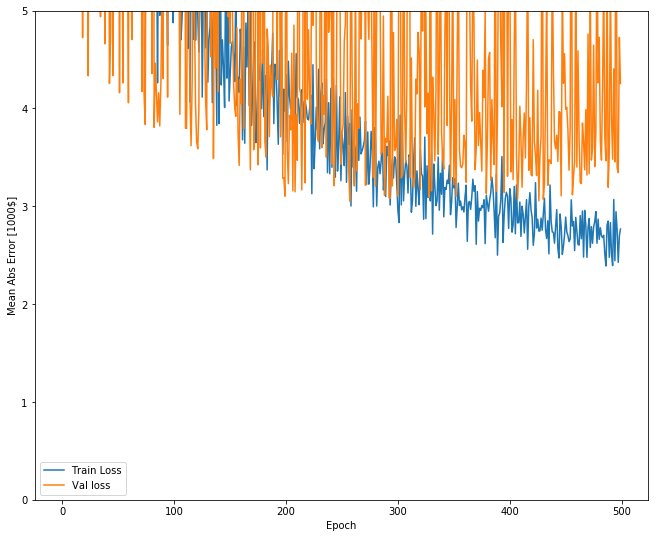

In [36]:
plot_history(history_rmsprop)

As you can see, not only we are over-fitting (since the training error is less than validation error), the training is very unstable. What could be the reason for it? While working with Neural Networks, one main issue as you we saw earlier in the visualizations from Stochastic Gradient Descent is that the optimization method cannot break symmetry. Let us build another model with the same architecture, but change the optimizer:

In [37]:
def build_model():
    model = keras.Sequential([
        keras.layers.Dense(64, activation=tf.nn.relu,
                       input_shape=(X_train.shape[1],)),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dense(1)
  ])

    optimizer = optimizer = tf.train.AdadeltaOptimizer(1., 0.95, 1e-6)    

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
    return model

model_ada = build_model()
model_ada.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


### Training


The *fit* method needs to be evoked on the model object that you created to start the training process:

In [38]:
EPOCHS = 500

# Store training stats
history_ada = model_ada.fit(X_train, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0)

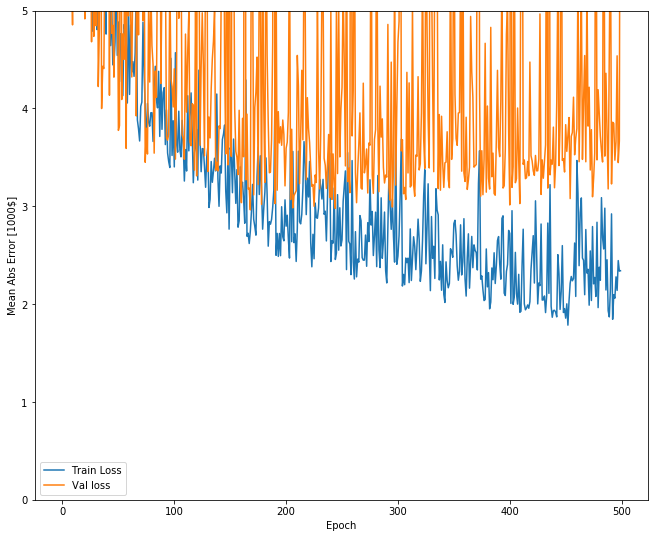

In [39]:
plot_history(history_ada)

As you can see, our assumption was wrong about unstability of RMSProp. In this case, our training is still very unstable. Let us before more investigation, try to find out how an unstable training, affects the prediction of a Neural Network:

### Evaluation

In [40]:
[loss_ada, mae_ada] = model_ada.evaluate(X_test, y_test, verbose=0)
[loss_rmsprop, mae_rmsprop] = model_rmsprop.evaluate(X_test, y_test, verbose=0)

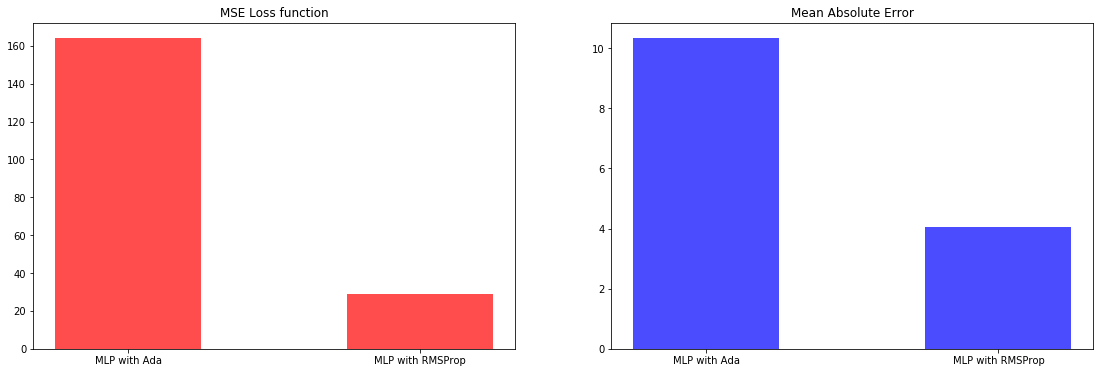

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(19, 6), sharex=True)

N = np.arange(2)
width = 0.5

ax[0].bar(N, [loss_ada, loss_rmsprop], width, label='Loss', alpha=0.7, color='red')
ax[0].set_xticks(N)
ax[0].set_xticklabels(('MLP with Ada', 'MLP with RMSProp'))
ax[0].set_title('MSE Loss function')

ax[1].bar(N, [mae_ada, mae_rmsprop], width, label='Mean Asbolute Error', alpha=0.7, color='blue')
ax[1].set_xticks(N)
ax[1].set_xticklabels(('MLP with Ada', 'MLP with RMSProp'))
ax[1].set_title('Mean Absolute Error')

plt.show()

The above visualization shows that RMSProp is out-performing the Ada optimzier. Please remember that the hyperparameters are not yet optimized.Let us look at the prediction metrics:

### Prediction (Inference)

In [43]:
test_pred_ada = model_ada.predict(X_test).flatten()
test_pred_rmsprop = model_rmsprop.predict(X_test).flatten()

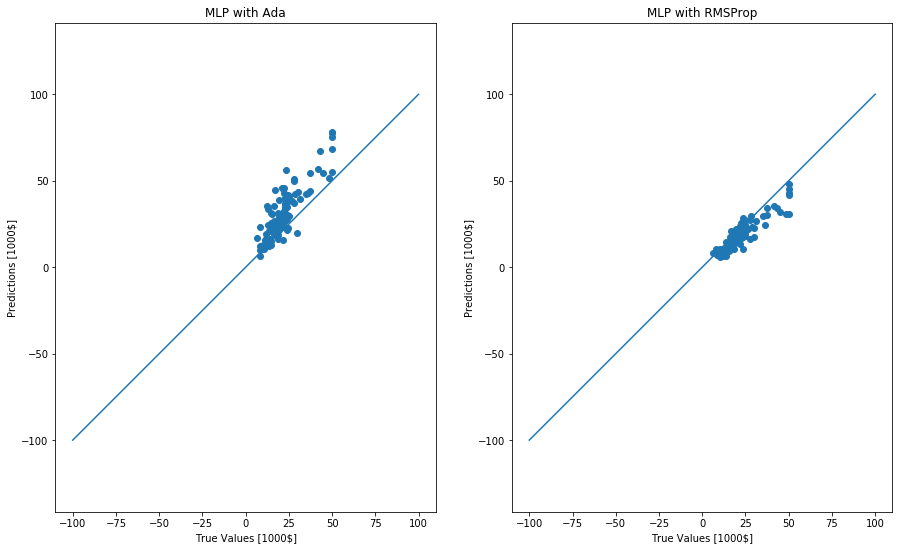

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(15, 9))


ax[0].scatter(y_test, test_pred_ada)
ax[0].set_xlabel('True Values [1000$]')
ax[0].set_ylabel('Predictions [1000$]')

ax[0].axis('equal')
ax[0].set_title('MLP with Ada')
ax[0].plot([-100, 100], [-100, 100])

ax[1].scatter(y_test, test_pred_rmsprop)
ax[1].set_xlabel('True Values [1000$]')
ax[1].set_ylabel('Predictions [1000$]')

ax[1].axis('equal')
ax[1].set_title('MLP with RMSProp')
ax[1].plot([-100, 100], [-100, 100])

plt.show()

So back to the unstable training, we need to mention that although in no formal formualtion is mentioned, **Backpropagation and Stochastic Gradient Descent algorithms are very unstable without mean normalization**. This is a rather weakenss of Neural Networks and all methods which rely on the sub-gradients of data in order to perform optimization:

In [46]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

train_norm = (X_train - mean) / std
test_norm = (X_test - mean) / std

print(train_norm[0])

[ 1.43910768 -0.49559343  1.02669166 -0.29329423  1.25887674 -1.44077268
  1.05736657 -1.13295032  1.67595875  1.55633679  0.81290414  0.43472666
  2.50177533]


In [47]:
EPOCHS = 500

# Store training stats
history_rmsprop = model_rmsprop.fit(train_norm, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0)

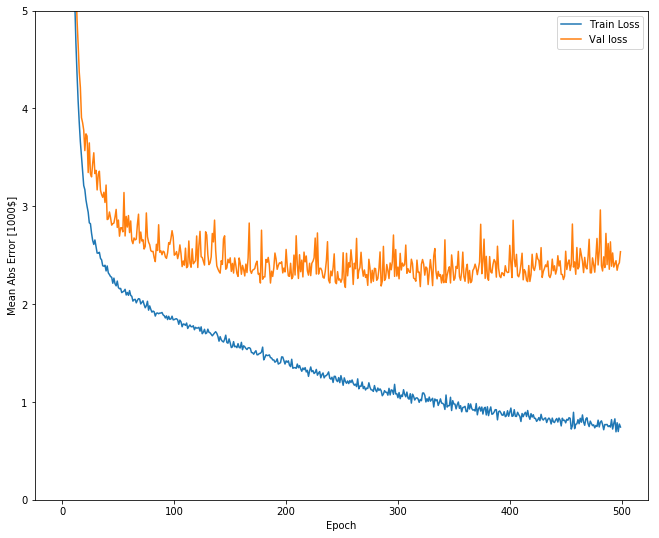

In [48]:
plot_history(history_rmsprop)

One question can be, are we sure that all variants of Stochastic Gradient Descent can be improved by this technique? And the answer is yes:

In [49]:
EPOCHS = 500

# Store training stats
history_ada = model_ada.fit(train_norm, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0)

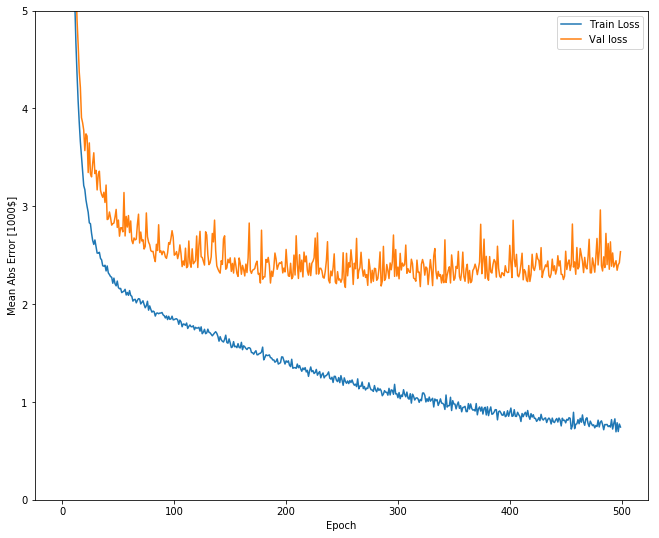

In [50]:
plot_history(history_rmsprop)

In [51]:
[loss_ada, mae_ada] = model_ada.evaluate(X_test, y_test, verbose=0)
[loss_rmsprop, mae_rmsprop] = model_rmsprop.evaluate(X_test, y_test, verbose=0)

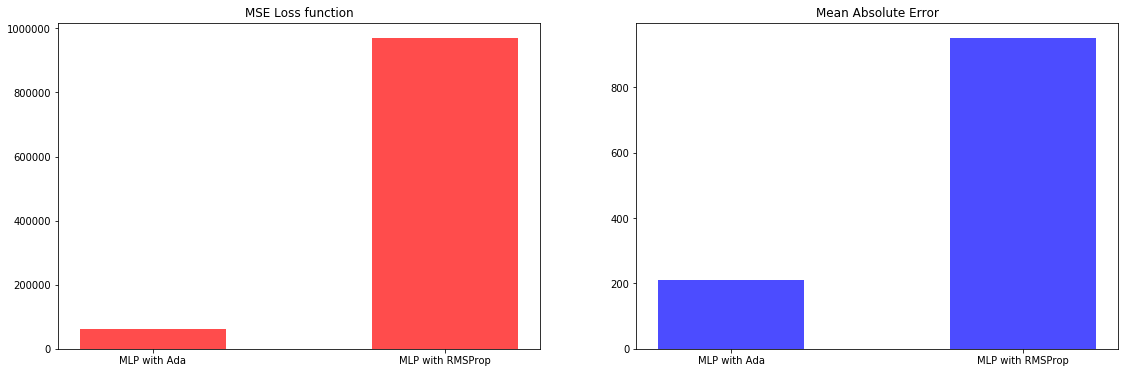

In [52]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(19, 6), sharex=True)

N = np.arange(2)
width = 0.5

ax[0].bar(N, [loss_ada, loss_rmsprop], width, label='Loss', alpha=0.7, color='red')
ax[0].set_xticks(N)
ax[0].set_xticklabels(('MLP with Ada', 'MLP with RMSProp'))
ax[0].set_title('MSE Loss function')

ax[1].bar(N, [mae_ada, mae_rmsprop], width, label='Mean Asbolute Error', alpha=0.7, color='blue')
ax[1].set_xticks(N)
ax[1].set_xticklabels(('MLP with Ada', 'MLP with RMSProp'))
ax[1].set_title('Mean Absolute Error')

plt.show()

Now it is ADa that is outperforming the RMSProp. You can clearly see how much a stable training has benefited the evaluation.

### Tensorboard

One of the main benefits of using libraries like Tensorflow are the tools you can use with them and Tensorboard has turned into one of best tools in Data Science projects. 

Let us very briefly go through the usefulness of looking at Tensorboard. First in order to open the Tensorfboard, you need to run the following command:

In [75]:
tb_callback = keras.callbacks.TensorBoard(log_dir='./board', 
                                         histogram_freq=10, write_grads=True, write_images=True)

history_ada_tb = model_ada.fit(train_norm, y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, write_grads=True,
                    callbacks=[tb_callback])

In [76]:
!tensorboard --logdir=./board

TensorBoard 1.5.1 at http://amir-ubuntu:6006 (Press CTRL+C to quit)
W1125 12:31:46.584155 Thread-1 application.py:273] path /[[_dataImageSrc]] not found, sending 404
^C


<img src="tb_1.png" style="width:700px;height:500px"/>

<img src="tb_2.png" style="width:700px;height:500px"/>

<img src="tb_3.png" style="width:700px;height:500px"/>

<img src="tb_4.png" style="width:700px;height:500px"/>

<img src="tb_5.png" style="width:700px;height:500px"/>

### Nump with GPU-acceleration

In recent years, due to the huge growth in digitalization, a huge growth is digital footprint is visible. This increase has led to the use of larger computational powers to accelerate our computational power. These days, it is affordable to buy GPU units for our Personal Computers (PC) or even use cloud-based services. In this tutorial, I am using my PC's GPU unit.GPUs are all computational performances are very sensitive to the settings you are running them. You need to be at least careful regarding comparing approaches in at least three dimensions:

* Operating System (OS)
* Central processing unit (CPU) 
* Graphical processing unit (GPU)

Let us go through ways to check the information we are using in this tutorial (please remember that these are Linux commands and they cannot be exactly running on other types of Operating Systems, however equivalent commands exist for any operating systems: 

#### Operating System (OS)

In [ ]:
!lsb_release -a

#### Central Processing Unit

In [ ]:
!cat /proc/cpuinfo  | grep 'name'| uniq

#### Graphical Processing Unit

In order to get information about your GPU, you can run the following command in UBUNTU:

In [ ]:
!lspci  -v -s  $(lspci | grep ' VGA ' | cut -d" " -f 1)

You also need to check your GPU drivers, especially CUDA for this tutorial: 

In [ ]:
! nvcc --version

### Cupy

CuPy is an open-source matrix library accelerated with NVIDIA CUDA. It also uses CUDA-related libraries including cuBLAS, cuDNN, cuRand, cuSolver, cuSPARSE, cuFFT and NCCL to make full use of the GPU architecture. 

In [ ]:
!pip install cupy-cuda90

In [ ]:
import numpy as np
import cupy as cp

#### Benchmarks: Numpy vs. Cupy

#### Matrix Multiplication

Let us build a case first for GPU enabled computation. Imagne you have two matrices and you would like to perform matrix multiplication, as we increase the size of the dimensions, we start to hit an issue: 

In [ ]:
import time

time_per_dimension_cpu = {}
dimensions = [20, 50, 100, 500, 1000, 2000, 5000, 8000, 10000, 20000, 50000]

for dim in dimensions: 
    print('Calcualting a Matrix for dim: {}'.format(dim))
    
    start = time.time()
    
    a = np.random.rand(dim, dim)
    b = np.random.rand(dim, dim)
    c = np.matmul(a, b)
    
    end = time.time()
    
    # Free up variables for garbage collector
    a = None
    b = None
    c = None
    
    time_per_dimension_cpu[dim] = end - start

A MemoryError hits us at 50000 as our initial dimension. Let us run the code once again with less dimensions: 

In [ ]:
import time

time_per_dimension_cpu = {}
dimensions = [20, 50, 100, 500, 1000, 2000, 5000, 8000, 10000, 20000]

for dim in dimensions: 
    print('Calcualting a Matrix for dim: {}'.format(dim))
    
    start = time.time()
    
    a = np.random.rand(dim, dim)
    b = np.random.rand(dim, dim)
    c = np.matmul(a, b)
    
    end = time.time()
    
    # Free up variables for garbage collector
    a = None
    b = None
    c = None
    
    time_per_dimension_cpu[dim] = end - start

Let us look at the result:

In [ ]:
time_per_dimension_cpu

### Cupy

In [ ]:
import time

time_per_dimension_gpu = {}
dimensions = [20, 50, 100, 500, 1000, 2000, 5000, 8000, 10000, 20000]

for dim in dimensions: 
    print('Calcualting a Matrix for dim: {}'.format(dim))
    
    start = time.time()
    
    a = cp.random.rand(dim, dim)
    b = cp.random.rand(dim, dim)
    c = cp.matmul(a, b)
    
    end = time.time()
    
    # Free up variables for garbage collector
    a = None
    b = None
    c = None
    
    time_per_dimension_gpu[dim] = end - start

Okay so now we have come to realize one drawback of using GPU computations. In the CPU computation phase, after a MemoryError happened after 50000 as our initial dimension however in GPU computation with Cupy, due to the fact that GPUs have less memory, the OutOfMemoryError is happening at 2000. This is something that you need to know, although CPU compuations can be slower, CPU can have access to more memory, since they are cheaper and much more accessible. 

Let us run the code with less dimensions:

In [ ]:
import time

time_per_dimension_gpu = {}
dimensions = [20, 50, 100, 500, 1000, 2000, 5000, 8000, 10000]

for dim in dimensions: 
    print('Calcualting a Matrix for dim: {}'.format(dim))
    
    start = time.time()
    
    a = cp.random.rand(dim, dim)
    b = cp.random.rand(dim, dim)
    c = cp.matmul(a, b)
    
    end = time.time()
    
    # Free up variables for garbage collector
    a = None
    b = None
    c = None
    
    time_per_dimension_gpu[dim] = end - start

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')


fig, axs = plt.subplots(1, 1, figsize=(11, 9), sharey=True)
axs.scatter(time_per_dimension_cpu.keys(), time_per_dimension_cpu.values(), alpha=0.7, label='CPU')
axs.scatter(time_per_dimension_gpu.keys() , time_per_dimension_gpu.values(), alpha=0.7, label='GPU')

axs.legend()

axs.set_xlabel('Matrix Multiplication Dimensions')
axs.set_ylabel('Matrix Multiplication Dimensions')

plt.show()